## Density-Based Spatial Clustering of Applications with Noise

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

import scipy
from scipy.sparse import csgraph
from numpy import linalg as LA

from IPython.display import display
from kneed import KneeLocator

import matplotlib.style as style
style.use("fivethirtyeight")

import sys

In [2]:
# dataset = pd.read_csv('./../Datasets/tmdb_prepro.csv')
dataset = pd.read_csv('./../Datasets/movies46k_prepro_onehot.csv')

In [3]:
# pd.set_option('display.max_columns', 500)
text_columns = ['original_title', 'overview', 'title', 'keywords', 'actors', 'characters', 'original_language']
# text_columns = ['release_date', 'original_title', 'overview', 'id', 'tagline', 'title', 'keywords', 'actors', 'characters', 'original_language']
df = dataset.drop(columns=text_columns)
display(pd.DataFrame(df.describe()))


df = StandardScaler().fit_transform(df)
# display(pd.DataFrame(pd.DataFrame(df).describe()))


## PCA (works well with dense data)
# variance_retention = 0.70
# pca = PCA(variance_retention)
# principalComponents = pca.fit_transform(df)
# df = pd.DataFrame(principalComponents)

## LDA works well with sparse data (a lot of zeroes)
svd = TruncatedSVD(n_components=20, algorithm='randomized')
df = svd.fit_transform(df)

display(pd.DataFrame(df))

,Unnamed: 0,budget,popularity,revenue,runtime,vote_average,vote_count,male_count,female_count,undefined_gender_count,...,en,fr,es,de,it,ru,zh,ja,pt,ar
count,4803.000000,4.803000e+03,4803.000000,4.803000e+03,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,...,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000
mean,2401.000000,2.904504e+07,21.492301,8.226064e+07,106.830939,6.092172,690.217989,7.036852,5.031855,10.054341,...,0.933791,0.090985,0.073079,0.054549,0.039142,0.038518,0.022278,0.020196,0.014158,0.013950
std,1386.651002,4.072239e+07,31.816650,1.628571e+08,22.714124,1.194612,1234.585891,11.176134,5.368746,7.942877,...,0.248672,0.287617,0.260294,0.227122,0.193953,0.192462,0.147601,0.140684,0.118154,0.117294
min,0.000000,0.000000e+00,0.000000,0.000000e+00,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1200.500000,7.900000e+05,4.668070,0.000000e+00,94.000000,5.600000,54.000000,1.000000,2.000000,5.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2401.000000,1.500000e+07,12.921594,1.917000e+07,103.000000,6.200000,235.000000,4.000000,4.000000,8.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3601.500000,4.000000e+07,28.313505,9.291719e+07,117.500000,6.800000,737.000000,8.000000,6.000000,13.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4802.000000,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,164.000000,107.000000,88.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,15.990212,-0.176256,-0.730806,1.871311,6.485965,-4.035771,-0.589746,1.410088,-3.803130,-2.041469,-1.521900,0.778431,0.400082,-3.099083,-0.340479,0.786658,0.554953,-2.661555,0.554327,2.180883
1,9.786209,-1.882136,-0.216099,2.237052,1.009084,-1.859796,-1.939217,-1.445413,-0.548465,0.303232,0.170172,-0.237103,1.123699,-1.119176,-0.427157,-0.043874,-0.639978,-0.280883,0.091956,-0.844057
2,9.986522,3.098139,0.254324,0.554913,1.241425,2.888676,0.497648,-0.303323,-2.336705,-2.600658,-2.522427,-0.869543,-0.282203,1.374426,1.140398,-2.302602,1.055516,-0.959169,-2.770374,2.025423
3,12.356159,2.998776,1.083341,-2.679376,4.189618,-3.528028,0.433953,-1.158410,-0.583231,-0.629036,-1.250333,-0.577747,-1.955063,2.061221,0.909633,-1.630753,0.387490,0.956017,0.511283,0.422821
4,5.882123,-1.999146,-1.267532,1.416721,-0.677321,-0.861954,-1.366093,-0.479002,-0.792365,0.306988,0.322483,0.048438,0.442841,0.338207,-1.306045,0.756147,-0.282814,-0.018879,-0.581126,-1.169214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,-1.306251,0.815574,-2.199340,-0.188761,-0.539266,0.327543,1.185716,-2.260228,-0.880542,-0.525455,-3.673058,1.141577,-0.332639,1.319952,0.267704,-2.302761,-0.871978,-0.983710,-0.113890,0.622510
4799,-3.662925,-0.654794,0.707360,1.810699,1.078441,-0.742893,1.544363,0.122956,-0.998833,-0.441178,0.075760,0.970852,-0.589171,-0.741737,-0.341752,-1.121596,-0.651864,0.599980,0.231936,0.485452
4800,-2.837466,-0.296331,2.119444,-0.532148,0.072765,-0.645439,-0.128339,0.065190,-0.236183,-0.367968,0.250478,0.515411,-0.184806,-0.937980,-0.283762,0.095158,-0.173484,-0.464366,-0.059662,0.370749
4801,-2.691382,0.042661,-0.776930,1.395816,-1.723285,-3.305977,3.230584,-0.952570,0.318638,-0.424105,-0.170701,-1.948340,1.528433,-0.997266,0.280846,0.955344,0.967480,-0.136604,-0.149008,0.045602


# Eigengap heuristics to determine number of clusters

Text(0, 0.5, 'Distance')

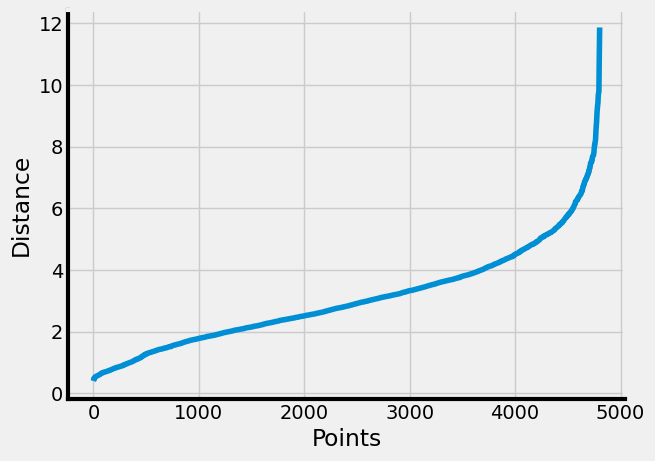

In [4]:
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(df)

distances, indices = neighbors.kneighbors(df)
distances = np.sort(distances[:,10], axis=0)

fig, ax = plt.subplots(1)

ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='y', colors='black')
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

eps = 4.79521620576913


/tmp/ipykernel_34439/3697256007.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(knee.x, knee.y, "b", label="data", c='black')


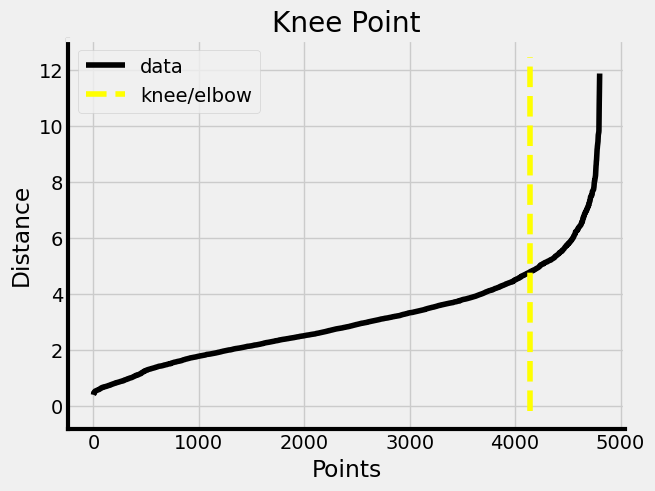

In [5]:
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

plt.plot(knee.x, knee.y, "b", label="data", c='black')
plt.vlines(knee.knee, plt.ylim()[0], plt.ylim()[1], linestyles="--", label="knee/elbow", color='yellow')

plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().xaxis.label.set_color('black')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().yaxis.label.set_color('black')
plt.gca().tick_params(axis='y', colors='black')
plt.xlabel("Points", c='black')
plt.ylabel("Distance", c='black')
plt.title("Knee Point", c='black')
plt.legend(loc='best', labelcolor='black')

eps = distances[knee.knee]
print("eps =", eps)

In [6]:
dbscan_cluster = DBSCAN(eps=eps, min_samples=8)
dbscan_cluster.fit(df)

# Number of Clusters
labels = dbscan_cluster.labels_
N_clus = len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(dbscan_cluster.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)


Estimated no. of clusters: 3
Estimated no. of noise points: 277


# Silhouette method to determine minimum distance

In [7]:
silhouette_avg_samples = []
k_range = 30

for samples in range(2, k_range):
    clusterer = DBSCAN(eps=eps, min_samples=samples)
    cluster_labels = clusterer.fit_predict(df)
    
    silhouette_avg = silhouette_score(df, cluster_labels)
    silhouette_avg_samples.append(silhouette_avg)

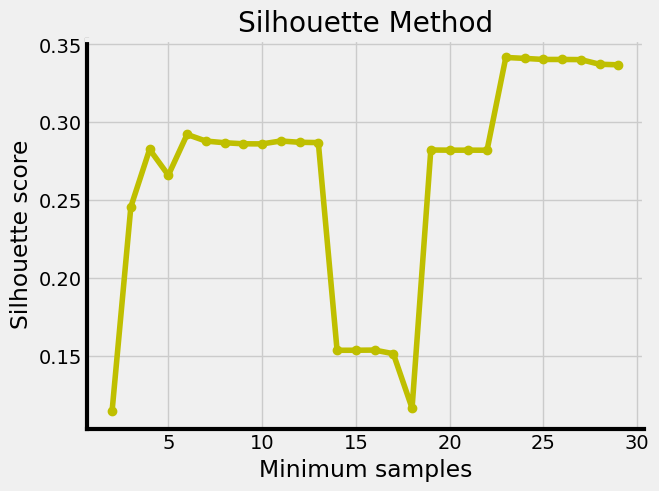

In [8]:
fig, ax = plt.subplots(1)

ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='y', colors='black')

ax.plot(range(2, k_range), silhouette_avg_samples, '-o', c = 'y')
ax.xaxis.get_major_locator().set_params(integer=True)

plt.xlabel("Minimum samples")
plt.ylabel("Silhouette score")
plt.title("Silhouette Method", c = 'black')
plt.show()

In [9]:
sc = DBSCAN(eps=eps, min_samples=23)

sc.fit(df)

DBSCAN(eps=4.79521620576913, min_samples=23)

# Results
* We use DBSCAN here to combat both the high dimensionality of our data and the fact that our data is very noisy.
* DBSCAN is very robust with reducing noise points as it is a density based clustering algorithm.
* We find the optimal parameters for DBSCAN as follows:
    * We utilize Eigengap hueristics to determine the epsilon value and get idea of the number of clusters (eps = 4.758129289162965)
    * We use the Silhouette method to determine the minimum samples parameter (minimum samples = 23)
    